In [72]:
# Import necessary packages for Exam
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
from scipy import optimize 
from scipy import interpolate
from scipy import linalg
from matplotlib import cm

# Linear regression

Consider the following **linear equation:**

$$y_i = \beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i} + \epsilon_i$$

Assume you have access to data of the **independent variables** ($x_{1,i}$, $x_{2,i}$) and the **dependent variable** ($y_i$) for $N$ individuals, where $i$ indexes individuals. The variable $\epsilon_i$ is a mean-zero **stochastic shock**.

Assume the **data generating process** is given by:

In [62]:
def DGP(N):
    
    # a. independent variables
    x1 = np.random.normal(0,1,size=N)
    x2 = np.random.normal(0,1,size=N)
    
    # b. errors
    eps = np.random.normal(0,1,size=N)
    
    extreme = np.random.uniform(0,1,size=N)
    eps[extreme < 0.05] += np.random.normal(-5,1,size=N)[extreme < 0.05]
    eps[extreme > 0.95] += np.random.normal(5,1,size=N)[extreme > 0.95]
    
    # c. dependent variable
    y = 0.1 + 0.3*x1 + 0.5*x2 + eps
    
    return x1, x2, y

**The data you have access to is:**

In [63]:
np.random.seed(2020)
x1,x2,y = DGP(10000)

**Question 1:** Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using **ordinary least squares (OLS)** implemented with **matrix algebra** by

$$ \hat{\mathbf{\beta}} = (\mathbf{X}^{\prime}\mathbf{X})^{-1}\mathbf{X}^{\prime}\mathbf{y} $$

where $\mathbf{X}^{\prime}$ is the transpose of $\mathbf{X}$ and

$$\mathbf{y} = 
\pmatrix{ y_1 \cr y_2 \cr  \vdots \cr y_N 
}
, \quad \mathbf{X} = \pmatrix{
1 & x_{1,1} & x_{2,1} \cr 
1 & x_{1,2} & x_{2,2} \cr 
\vdots & \vdots \cr 
1 & x_{1,N} & x_{2,N} 
}$$

In [64]:
# a. Create OLS solving function
def ols_solver(x1, x2, y):
    '''
    Find vector of beta coefficients using OLS via matrix algebra
    
    Arguments:
    x1(list): numpy array of x1 values
    x2(list): numpy array of x2 values
    y(list): numpy array of y values
    
    returns: 
    beta(list): vector of estimated betas
    '''
    
    # i. Create x and y matrixes
    num = len(x1)
    one_vector = np.ones((num,1))
    x1_vec = x1.reshape(-1,1)
    x2_vec = x2.reshape(-1,1)
    xm = np.concatenate((one_vector, x1_vec, x2_vec), axis = 1)
    y_vec = y.reshape(-1,1)
    
    # ii. Solve for beta coefficients via matrix algebra
    beta = np.linalg.inv(xm.T@xm)@xm.T@y_vec
    
    return beta

In [104]:
# b. Generate vector of beta coefficients and output results
betas = ols_solver(x1, x2, y)
print('Our vector of beta coefficients: '+'B_0 = '+ str(betas[0,0])+' '+'B_1 ='+str(betas[1,0])+' '+'B_2 = '+str(betas[2,0]))

Our vector of beta coefficients: B_0 = 0.5134586176350806 B_1 =0.3783025160447901 B_2 = 0.4991451554852664


**Question 2:** Construct a 3D plot, where the data is plotted as scattered points, and the prediction of the model is given by the plane

$$\hat{y}_i = \hat{\beta}_0 + \hat{\beta}_1 x_{1,i} + \hat{\beta}_2 x_{2,i}$$

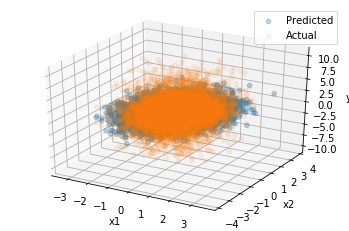

In [66]:
# a. Finding predicted y_values
y_hat = []
for i, x in enumerate(x1):
    y_point=betas[0,0]+betas[1,0]*x1[i]+betas[2,0]*x2[i]
    y_hat.append(y_point)
    
# b. create scatter plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x1, x2, y_hat, alpha = 0.3, label = 'Predicted')
ax.scatter(x1, x2, y, alpha = 0.1, label = 'Actual')

# c. label and output results 
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
ax.legend()

plt.show()

**Question 3:** Esimtate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using a **numerical solver** to solve the ordinary least square problem, shown below, directly. Compare your results with the matrix algebra results.

$$ \min_{\mathbf{\beta}} \sum^N_{i=1} (y_i - (\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}) )^2 $$

In [67]:
# a. Create objective function 

def objective(x1, x2, y, b):
    '''
    Return sum of forcast errors
    
    Arguments:
    x1(list): Numpy array of x1 values
    x2(list): Numpy array of x2 values
    y(list): Numpy array of y values
    b(list): list of beta coefficients
    
    Return:
    total(float): Sum of all forcast errors
    '''
    total = 0 
    for i, x in enumerate(x1):
        diff = (y[i] - (b[0]+b[1]*x1[i]+b[2]*x2[i]))**2
        total += diff
    
    return total

# b. Create optimizer function
def opt(x1, x2, y):
    '''
    Solve to find optimal beta coefficeints to minimize forcast error
    
    Arguments:
    x1(list): Numpy array of x1 values
    x2(list): Numpy array of x2 values
    y(list): Numpy array of y values
    
    Return:
    result(list): list of optimal beta coefficeints 
    '''
    obj = lambda b: objective(x1, x2, y, b)
    bound = (0, 1)
    bounds = (bound, bound, bound)
    x0 =(0.1, 0.1, 0.1)
    result = sp.optimize.minimize(obj, x0, method='SLSQP', bounds=bounds)
    
    return result.x
        
optimal_beta = opt(x1, x2, y)    

# c. Compare results with Matrix Algebra method to 3 decimal points
print('b0 = '+str(optimal_beta[0]))
print('b1 = '+str(optimal_beta[1]))
print('b2 = '+str(optimal_beta[2]))
print('Is b0 from the Matrix Algebra method equal to b0 from numerical solver method?: '+str(round(betas[0,0], 3)==round(optimal_beta[0], 3)))
print('Is b1 from the Matrix Algebra method equal to b1 from numerical solver method?: '+str(round(betas[1,0], 3)==round(optimal_beta[1], 3)))
print('Is b2 from the Matrix Algebra method equal to b2 from numerical solver method?: '+str(round(betas[2,0], 3)==round(optimal_beta[2], 3)))

b0 = 0.09568152474470845
b1 = 0.29294972815958786
b2 = 0.5033291060913825
Is b0 from the Matrix Algebra method equal to b0 from numerical solver method?: True
Is b1 from the Matrix Algebra method equal to b1 from numerical solver method?: True
Is b2 from the Matrix Algebra method equal to b2 from numerical solver method?: True


**Question 4:** Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using **least absolute deviations (LAD)** using a numerical solver to solve the following problem directly: 

$$  \min_{\beta} \sum^N_{i=1} |y_i - (\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}) | $$

where $|z|$ is the absolute value of $z$.

In [68]:
# a. Create objective function 

def objective_abs(x1, x2, y, b):
    '''
    Return sum of forcast errors
    
    Arguments:
    x1(list): Numpy arrau of x1 values
    x2(list): Numpy array of x2 values
    y(list): Numpy array of y values
    b(list): list of beta coefficients
    
    Return:
    total(float): Sum of all forcast errors
    '''
    total = 0 
    for i, x in enumerate(x1):
        diff = abs(y[i] - (b[0]+b[1]*x1[i]+b[2]*x2[i]))
        total += diff
    
    return total

# b. Create optimizer function
def opt_abs(x1, x2, y):
    '''
    Solve to find optimal beta coefficeints to minimize forcast error
    
    Arguments:
    x1(list): Numpy array of x1 values
    x2(list): Numpy array of x2 values
    y(list): Numpy array of y values
    
    Return:
    result(list): list of optimal beta coefficeints 
    '''
    obj = lambda b: objective_abs(x1, x2, y, b)
    bound = (0, 1)
    bounds = (bound, bound, bound)
    x0 =(0.1, 0.1, 0.1)
    result = sp.optimize.minimize(obj, x0, method='SLSQP', bounds=bounds)
    
    return result.x
        
optimal_beta_abs = opt_abs(x1, x2, y)    

# c. Compare results with Matrix Algebra method to 3 decimal points
print('b0 = '+str(optimal_beta_abs[0]))
print('b1 = '+str(optimal_beta_abs[1]))
print('b2 = '+str(optimal_beta_abs[2]))
print('Is b0 from the Matrix Algebra method equal to b0 from numerical solver method?: '+str(round(betas[0,0], 3)==round(optimal_beta_abs[0], 3)))
print('Is b1 from the Matrix Algebra method equal to b1 from numerical solver method?: '+str(round(betas[1,0], 3)==round(optimal_beta_abs[1], 3)))
print('Is b2 from the Matrix Algebra method equal to b2 from numerical solver method?: '+str(round(betas[2,0], 3)==round(optimal_beta_abs[2], 3)))

b0 = 0.09226137634354298
b1 = 0.30746471356899374
b2 = 0.5115487004050594
Is b0 from the Matrix Algebra method equal to b0 from numerical solver method?: False
Is b1 from the Matrix Algebra method equal to b1 from numerical solver method?: False
Is b2 from the Matrix Algebra method equal to b2 from numerical solver method?: False


**Question 5:** Set $N = 50$. Repeat the estimation using the **OLS** and **LAD** methods $K=5000$ times, drawing a new random sample from the data generating process each time. Compare the estimates from each method using histograms. Which method do you prefer? Explain your choice.

VARIANCE OF BETAS:
variance of beta 0 in OLS method is 0.076 and in LAD method is 0.023
variance of beta 0 in OLS method is 0.080 and in LAD method is 0.038
variance of beta 0 in OLS method is 0.081 and in LAD method is 0.041

AVERAGE BETAS:
average value of beta 0 in OLS method is 0.102, while in LAD method is 0.143
average value of beta 1 in OLS method is 0.303, while in LAD method is 0.310
average value of beta 2 in OLS method is 0.500, while in LAD method is 0.499


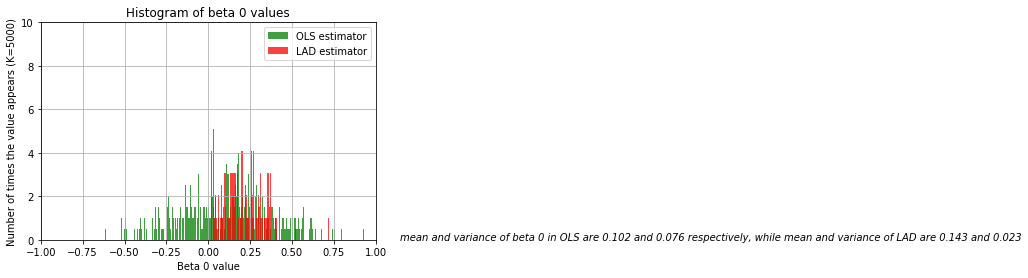

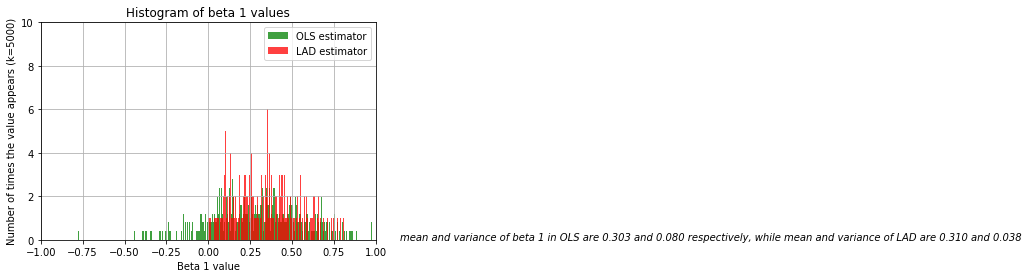

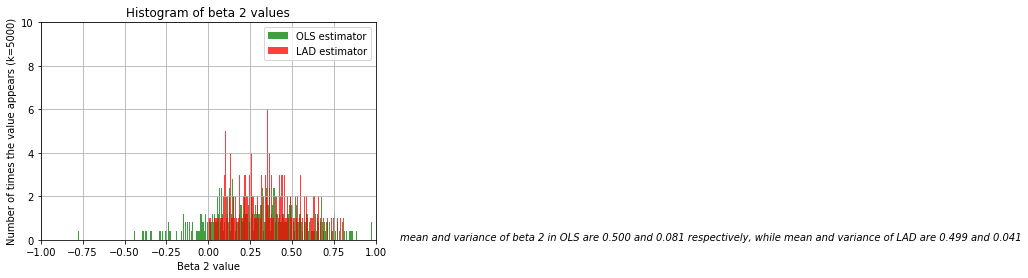

In [70]:
beta0list= np.zeros(5000) #create an empty list of beta 0 values for the OLS method
beta1list= np.zeros(5000) #create an empty list of beta 1 values for the OLS method
beta2list= np.zeros(5000) #create an empty list of beta 2 values for the OLS method

beta0listLAD= np.zeros(5000) #create an empty list of beta 0 values for the LAD method
beta1listLAD= np.zeros(5000) #create an empty list of beta 1 values for the LAD method
beta2listLAD= np.zeros(5000) #create an empty list of beta 2 values for the LAD method

np.random.seed(2020)

sumofbeta0ols=0 #create an empty variable which we will use for calculating mean value of beta 0 for OLS method
sumofbeta0lad=0 #create an empty variable which we will use for calculating mean value of beta 1 for OLS method
sumofbeta1ols=0 #create an empty variable which we will use for calculating mean value of beta 2 for OLS method
sumofbeta1lad=0 #create an empty variable which we will use for calculating mean value of beta 0 for LAD method
sumofbeta2ols=0 #create an empty variable which we will use for calculating mean value of beta 0 for LAD method
sumofbeta2lad=0 #create an empty variable which we will use for calculating mean value of beta 0 for LAD method
    
    
K=5000 #setting K equal to 5000, this will be the number of random values our methods will be tested

for i in range (0,K): #create a loop for K=5000 times
    
    
    x1,x2,y = DGP(N=50) 
    
    beta0list[i]=ols_solver(x1,x2,y)[0]  #each item on the list will be a beta 0 estimator of OLS solver for the random number created by the seed
    beta1list[i]=ols_solver(x1,x2,y)[1] #each item on the list will be a beta 1 estimator of OLS solver for the random number created by the seed
    beta2list[i]=ols_solver(x1,x2,y)[2] #each item on the list will be a beta 2 estimator of OLS solver for the random number created by the seed
    
    beta0listLAD[i]=opt_abs(x1, x2, y)[0] #each item on the list will be a beta 0 estimator of LAD solver for the random number created by the seed
    beta1listLAD[i]=opt_abs(x1, x2, y)[1] #each item on the list will be a beta 1 estimator of LAD solver for the random number created by the seed
    beta2listLAD[i]=opt_abs(x1, x2, y)[2] #each item on the list will be a beta 2 estimator of LAD solver for the random number created by the seed
    
    sumofbeta0ols+=beta0list[i] #add the value of beta 0 of OLS method to the sum of beta 0
    sumofbeta0lad+=beta0listLAD[i] #add the value of beta 1 of OLS method to the sum of beta 1
    sumofbeta1ols+=beta1list[i] #add the value of beta 2 of OLS method to the sum of beta 2
    sumofbeta1lad+=beta1listLAD[i] #add the value of beta 0 of LAD method to the sum of beta 0
    sumofbeta2ols+=beta2list[i] #add the value of beta 1 of LAD method to the sum of beta 1
    sumofbeta2lad+=beta2listLAD[i] #add the value of beta 2 of LAD method to the sum of beta 2
    
varbeta0ols = np.var(beta0list) #find the variance of beta 0 with OLS method
varbeta0lad = np.var(beta0listLAD) #find the variance of beta 0 with LAD method
varbeta1ols = np.var(beta1list) #find the variance of beta 1 with OLS method
varbeta1lad = np.var(beta1listLAD) #find the variance of beta 1 with LAD method
varbeta2ols = np.var(beta2list) #find the variance of beta 2 with OLS method
varbeta2lad = np.var(beta2listLAD) #find the variance of beta 2 with LAD method

print('VARIANCE OF BETAS:')
print ('variance of beta 0 in OLS method is ' + str("%.3f" % varbeta0ols) + ' and in LAD method is ' + str("%.3f" % varbeta0lad))  #print the variances of beta 0 with OLS and LAD method
print ('variance of beta 0 in OLS method is ' + str("%.3f" % varbeta1ols) + ' and in LAD method is ' + str("%.3f" % varbeta1lad))  #print the variances of beta 1 with OLS and LAD method
print ('variance of beta 0 in OLS method is ' + str("%.3f" % varbeta2ols) + ' and in LAD method is ' + str("%.3f" % varbeta2lad))  #print the variances of beta 2 with OLS and LAD method

print('')
avgbeta0ols=(sumofbeta0ols/K) #calculate the average beta 0 of OLS method for K=5000 values
avgbeta1ols=(sumofbeta1ols/K) #calculate the average beta 1 of OLS method for K=5000 values
avgbeta2ols=(sumofbeta2ols/K) #calculate the average beta 2 of OLS method for K=5000 values
avgbeta0lad=(sumofbeta0lad/K) #calculate the average beta 0 of LAD method for K=5000 values
avgbeta1lad=(sumofbeta1lad/K) #calculate the average beta 1 of LAD method for K=5000 values
avgbeta2lad=(sumofbeta2lad/K) #calculate the average beta 2 of LAD method for K=5000 values

print('AVERAGE BETAS:')
print('average value of beta 0 in OLS method is '+ str("%.3f" % avgbeta0ols)+ ', while in LAD method is '+ str("%.3f" % avgbeta0lad)) #print average beta 0 in OLS and in LAD methods
print('average value of beta 1 in OLS method is '+ str("%.3f" % avgbeta1ols) + ', while in LAD method is ' + str("%.3f" % avgbeta1lad)) #print average beta 1 in OLS and in LAD methods
print('average value of beta 2 in OLS method is ' + str("%.3f" % avgbeta2ols) + ', while in LAD method is ' + str("%.3f" % avgbeta2lad)) #print average beta 2 in OLS and in LAD methods

'''
#adding a visual representation of beta 0 values for OLS and LAD methods
plt.xlabel('beta 0 value distribution')
plt.ylabel('Beta 0 value')
plt.title('beta 0 value distribution in OLS and LAD methods')
plt.plot(beta0list, 'r--', beta0listLAD, 'bs')
plt.show()

#adding a visual representation of beta 1 values for OLS and LAD methods
plt.plot(beta1list, 'r--', beta1listLAD, 'bs')
plt.show()

#adding a visual representation of beta 2 values for OLS and LAD methods
plt.plot(beta2list, 'r--', beta2listLAD, 'bs')
plt.show()
'''

#plot a histogram which compares the distribution given by OLS and LAD methos for beta 0
n, bins, patches=plt.hist(beta0list, 5000, density=1, facecolor='g', alpha=0.75, label='OLS estimator')
n, bins, patches=plt.hist(beta0listLAD, 5000, density=1, facecolor='r', alpha=0.75, label='LAD estimator')

plt.xlabel('Beta 0 value')
plt.ylabel('Number of times the value appears (K=5000)')
plt.title('Histogram of beta 0 values')
#plt.text(3, .00001, r'$\mu=100,\ \sigma=15$')
t = ("mean and variance of beta 0 in OLS are " + str("%.3f" % avgbeta0ols)+ " and " + str("%.3f" % varbeta0ols)+ " respectively, while mean and variance of LAD are "+ str("%.3f" % avgbeta0lad)+ " and " + str("%.3f" % varbeta0lad))
plt.text(3, 0.00001, t, style='oblique', ha='center', rotation=0, wrap=True)
plt.axis([-1, 1, 0, 10])
plt.grid(True)
plt.legend()
plt.show()

#plot a histogram which compares the distribution given by OLS and LAD methos for beta 1
n2, bins2, patches2=plt.hist(beta1list, 5000, density=1, facecolor='g', alpha=0.75, label='OLS estimator')
n2, bins2, patches2=plt.hist(beta1listLAD, 5000, density=1, facecolor='r', alpha=0.75, label='LAD estimator')

plt.xlabel('Beta 1 value') #setting a title for x 
plt.ylabel('Number of times the value appears (k=5000)') #setting a title for y 
plt.title('Histogram of beta 1 values')
#plt.text(3, .00001, r'$\mu=100,\ \sigma=15$')
t = ("mean and variance of beta 1 in OLS are " + str("%.3f" % avgbeta1ols)+ " and " + str("%.3f" % varbeta1ols)+ " respectively, while mean and variance of LAD are "+ str("%.3f" % avgbeta1lad)+ " and " + str("%.3f" % varbeta1lad))
plt.text(3, 0.00001, t, style='oblique', ha='center', rotation=0, wrap=True)
plt.axis([-1, 1, 0, 10])
plt.grid(True)
plt.legend()
plt.show()

#plot a histogram which compares the distribution given by OLS and LAD methos for beta 2
n3, bins3, patches3=plt.hist(beta1list, 5000, density=1, facecolor='g', alpha=0.75, label='OLS estimator')
n3, bins3, patches3=plt.hist(beta1listLAD, 5000, density=1, facecolor='r', alpha=0.75, label='LAD estimator')

plt.xlabel('Beta 2 value')
plt.ylabel('Number of times the value appears (k=5000)')
plt.title('Histogram of beta 2 values')
#plt.text(3, .00001, r'$\mu=100,\ \sigma=15$')
t = ("mean and variance of beta 2 in OLS are " + str("%.3f" % avgbeta2ols)+ " and " + str("%.3f" % varbeta2ols)+ " respectively, while mean and variance of LAD are "+ str("%.3f" % avgbeta2lad)+ " and " + str("%.3f" % varbeta2lad))
plt.text(3, 0.00001, t, style='oblique', ha='center', rotation=0, wrap=True)
plt.axis([-1, 1, 0, 10])
plt.grid(True)
plt.legend()
plt.show()


Least absolute deviation (LAD) is an alternative method to the conventional ordinary least squares (OLS). While OLS estimates the coefficients that minimize the sum of squared residuals, LAD instead estimates the coefficients that minimizes the sum of the absolute residuals. As a result, the model’s accuracy increases, which can be seen from looking at the lower variance associated with the LAD Beta estimators. LAD has the advantage of being more resistant to outliers. For example, with small data sets, one big outlier can affect the OLS estimate. We can see from the  histograms above that the estimates obtained from LAD, as well as the mean estimates, are different from the ones obtained from OLS. The difference could be due to outliers but could also reflect that there is a difference between the median and the mean estimates of Beta. In the histograms and from our calculations we can see that the LAD method provides a lower variance for the three Beta estimators. As it is desirable to have as much precision as possible when estimating Beta, we prefer the estimator with the smaller variance, given that both are unbiased, which is LAD

# Durable purchases

Consider a **household** living in two periods.

In the **second period** it gets utility from **non-durable consumption**, $c$, and **durable consumption**, $d+\chi x$:

$$
\begin{aligned}
v_{2}(m_{2},d)&= \max_{c}\frac{(c^{\alpha}(d+\chi x)^{1-\alpha})^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
x &= m_{2}-c \\
c &\in [0,m_{2}]
\end{aligned}
$$

where 

* $m_2$ is cash-on-hand in the beginning of period 2
* $c$ is non-durable consumption
* $d$ is pre-commited durable consumption
* $x = m_2 - c$ is extra durable consumption
* $\rho > 1$ is the risk aversion coefficient
* $\alpha \in (0,1)$ is the utility weight on non-durable consumption
* $\chi \in (0,1)$ implies that extra durable consumption is *less* valuable than pre-comitted durable consumption
* the second constraint ensures the household *cannot* die in debt

The **value function** $v_2(m_2,d)$ measures the household's value of having $m_2$ at the beginning of period 2 with precomitted durable consumption of $d$. The optimal choice of non-durable consumption is denoted $c^{\ast}(m_2,d)$. The optimal extra durable consumption function is $x^{\ast}(m_2,d) = m_2-c^{\ast}(m_2,d)$.

Define the so-called **end-of-period 1 value function** as:

$$
\begin{aligned}
w(a,d)&\equiv\beta\mathbb{E}_{1}\left[v_2(m_2,d)\right]
\end{aligned}
$$

where 

$$
\begin{aligned}
m_2&= (1+r)a+y \\
y &= \begin{cases}
1-\Delta & \text{with prob. }\frac{1}{3}\\
1 & \text{with prob. }\frac{1}{3}\\
1+\Delta & \text{with prob. }\frac{1}{3}
\end{cases}\\
\end{aligned}
$$

and

* $a$ is assets at the end of period 1
* $\beta > 0$ is the discount factor
* $\mathbb{E}_1$ is the expectation operator conditional on information in period 1
* $y$ is income in period 2
* $\Delta \in (0,1)$ is the level of income risk (mean-preserving)
* $r$ is the return on savings

In the **first period**, the household chooses it's pre-comitted level of durable consumption for the next-period,

$$
\begin{aligned}
v_{1}(m_{1})&=\max_{d} w(a,d)\\&\text{s.t.}&\\
a&= m_{1}-d \\
d&\in [0,m_{1}]\\
\end{aligned}
$$

where $m_1$ is cash-on-hand in period 1. The second constraint ensures the household *cannot* borrow. The **value function** $v_1(m_1)$ measures the household's value of having $m_1$ at the beginning of period 1. The optimal choice of pre-committed durable consumption is denoted $d^{\ast}(m_1)$.

The **parameters** and **grids** for $m_1$, $m_2$ and $d$ should be:

In [73]:
# a. parameters
rho = 2
alpha = 0.8
beta = 0.96
r = 0.04
Delta = 0.25
chi = 0.9

# b. grids
m1_vec = np.linspace(1e-8, 10, 100)
m2_vec = np.linspace(1e-8,10,100)
d_vec = np.linspace(1e-8,5,100)

**Question 1:** Find and plot the functions $v_{2}(m_{2},d)$, $c^{\ast}(m_2,d)$, and $x^{\ast}(m_2,d)$. Comment.

In [74]:
# c. Create function to calulate second period utility function
def utility2(c,m2,d,chi,alpha,rho):
    ''' calculates utility based upon combinations of durable and non durable consumption.
    
    Arguments:
    
    c(float) = non durable consumption
    d(float) = pre-commited durable consumption
    x(float) = extra durable consumption which is financed by cash that is left after affording non-durable consumption
    rho(float)= risk aversion coefficient
    alpha(float) = relative utility weight on non durable consumption (in comparison with durable consumption)
    chi(float) = percentage of value of relative worth of extra durable consumption in comparison with the pre-comitted durable consumption
    
    Returns:
    utility 
    '''
    return (1/1-rho)*(c**alpha*(d+chi*(m2-c))**(1-alpha))**(1-rho) 

# d. Create function to optimize second period utility function for consumption given second period money on hand and pre-commited durable consumption
def best_choices_2(chi,alpha,rho):
    ''' Function used to find optimal levels of consumption given money holdings and pre committed durable consumption
    
    Arguments:
    rho(float)= risk aversion coefficient
    alpha(float) = relative utility weight on non durable consumption (in comparison with durable consumption)
    chi(float) = percentage of value of relative worth of extra durable consumption in comparison with the pre-comitted durable consumption
    
    
    Returns:
    v2_vec(list): List of utility given m2 and d
    c2_vec(list): List of optimal consumption given m2 and d
    x_vec(list): List of extra durable consumption
    d_vec(list): List of pre-commited consumption
    m_vec(list): List of cash on hand in period 2
    '''
    # a. Initialize primary paramaters
    
    v2_vec = np.empty((100,100))
    c2_vec = np.empty((100, 100))
    x_vec = np.empty((100, 100))
    m2_vec = np.linspace(1e-8,10,100)
    d_vec = np.linspace(1e-8,5,100)
    
    # b. solve for optimal consumption with different levels of money and pre-commited durable consumption
    for i,m2 in enumerate(m2_vec):
        for j,d in enumerate(d_vec):
            
            # i. negative utility function
            find = lambda c: -utility2(c,m2,d,chi,alpha,rho)
        
            # ii. initial guess 
            x0 = m2*1/2
        
            # iii. optimize consumption given money on hand and pre-commited durable consumption
            result = sp.optimize.minimize(find, x0, method='L-BFGS-B', bounds=((1e-8,m2),))
        
            # iv. save calculated results
            v2_vec[i, j] = -result.fun
            c2_vec[i, j] = result.x
            x_vec[i, j] = m2-result.x
     
    return v2_vec, c2_vec, x_vec, d_vec, m2_vec


In [75]:
# d. Generate grid variables 
v2_grid, c2_grid, x_grid, d_grid, m2_grid = best_choices_2(chi,alpha,rho) 

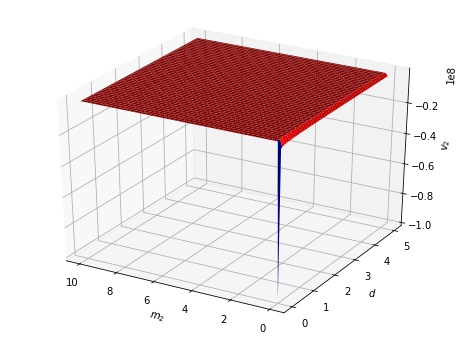

In [76]:
# e. Plot Second period utility given second period money on hand and pre-commited durable consumption

# Generate meshgrid for 3d plot
m2, d = np.meshgrid(m2_grid, d_grid, indexing='ij') 

# Create figure andplot points
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
cs = ax.plot_surface(m2,d,v2_grid,cmap=cm.jet)

# Label 
ax.set_xlabel('$m_2$')
ax.set_ylabel('$d$')
ax.set_zlabel('$v_2$')

# Invert axis
ax.invert_xaxis()


The plot over second period utility shows the the maximized utility given $m_2$ and $d$. 


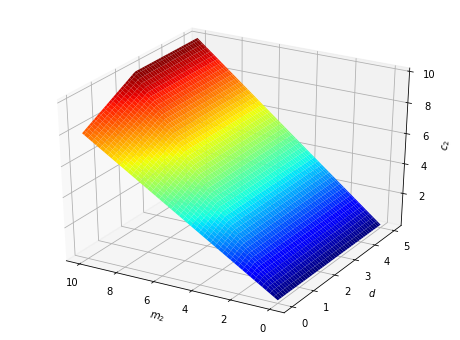

In [77]:
# f. Plot optimal second period consumption given second period money on hand and pre-commited durable consumption

# Generate meshgrid for 3d plot
m2, d = np.meshgrid(m2_grid, d_grid, indexing='ij') 


# Create figure andplot points
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
cs = ax.plot_surface(m2,d,c2_grid,cmap=cm.jet)

# Label 
ax.set_xlabel('$m_2$')
ax.set_ylabel('$d$')
ax.set_zlabel('$c_2$')

# Invert axis
ax.invert_xaxis()


The plot over optimal second period consumption shows that $c_2$ increases with an increase in $m_2$ and the peak consumption is reached slighlty after d = 2.


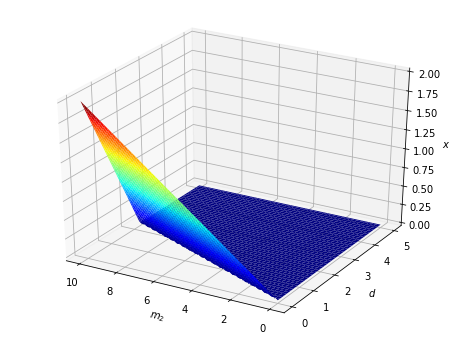

In [78]:
# g. Plot extra durable consumption given second period money on hand and pre-commited durable consumption

# Generate meshgrid for 3d plot
m2, d = np.meshgrid(m2_grid, d_grid, indexing='ij') 

# Create figure andplot points
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
cs = ax.plot_surface(m2,d,x_grid,cmap=cm.jet)

# Label 
ax.set_xlabel('$m_2$')
ax.set_ylabel('$d$')
ax.set_zlabel('$x$')

# Invert axis
ax.invert_xaxis()


The plot over extra durable consumption shows a corner solution for high values of $m_2$ and low values of $d$. Implying that $x$ increases with $m_2$ and for low values of $d$. 


**Question 2:** Find and plot the functions $v_{1}(m_{1})$ and $d^{\ast}(m_1)$. Comment.

Text(0.5, 0, '$m_1$')

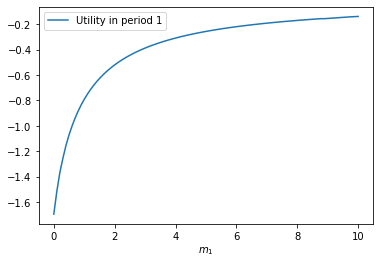

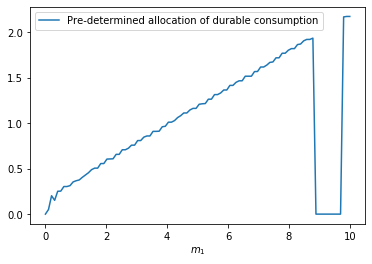

In [79]:
# a. Create first period utility function

def utility_1(beta, m1, d, r, v2_int, Delta):
    '''
    Utility function for first period 
    
    Arguments: 
    beta(float): Discount factor
    m1(float): Cash on hand in period 1
    d(float): pre-commited durable consumption
    r(float): return on savings
    v2_int(callable): Interolation of v2 given d and m2
    Delta(float): level of income risk
    
    Returns:
    Utility 
    '''
    # i. Value of second period utility given decreased income
    m2_low = (1+r)*(m1-d)+(1-Delta)
    v2_low = v2_int((m2_low, d))
    
    # ii. Value of second period utility given no change in income
    m2_nor = (1+r)*(m1-d) + 1
    v2_nor = v2_int((m2_nor, d))
    
     # iii. Value of second period utility given increased income
    m2_high = (1+r)*(m1-d) + (1 + Delta)
    v2_high = v2_int((m2_high, d))
    
    # iv. Take expectation
    v2 = (1/3)*v2_low + (1/3)*v2_nor + (1/3)*v2_high
    
    return beta*v2

# b. Solve for optimal first period allocation of pre-commited durable consumption 

def best_choices_1(beta, r, v2_int, Delta):
    ''' 
    Function used to find optimal levels of durable consumption for the next period 
    
    Arguments:
    beta(float): Discount factor
    r(float): return on savings
    v2_int(callable): Interolation of v2 given d and m2
    Delta(float): level of income risk
    
    Returns:
    v1_vec(list): List of utility given m1
    d_opt_vec(list): List of optimal pre-commited durable consumption
    m_vec(list): List of cash on hand in period 1
    '''
    # a. Initialize primary paramaters
    
    v1_vec = np.empty(100)
    m1_vec = np.linspace(1e-8, 10, 100)
    d_opt_vec = np.empty(100)
    
    # b. solve for optimal durable consumption next period with different levels of money on hand
    for i,m1 in enumerate(m1_vec):
            
        # i. negative utility function
        find = lambda d: -utility_1(beta, m1, d, r, v2_int, Delta)
        
        # ii. initial guess 
        x0 = m1*1/2
        
        # iii. optimize commited durable consumption given money on hand in period 1
        result = sp.optimize.minimize(find, x0, method='L-BFGS-B', bounds=((1e-8,m1),))
        
        # iv. save calculated results
        v1_vec[i] = -result.fun
        d_opt_vec[i] = result.x
     
    return v1_vec, d_opt_vec, m1_vec

# c. Construct the interpolater of period 2 utility
v2_int = interpolate.RegularGridInterpolator((m2_grid,d_grid), v2_grid, bounds_error=False,fill_value=None)

# d. Generate key variables by solving period 1 for optimal pre-commited durable consumption
v1_grid, d_opt_grid, m1_grid = best_choices_1(beta, r, v2_int, Delta)


# e. plot first period utility subject to money on hand in period 1
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(m1_grid,v1_grid,label='Utility in period 1')
ax.legend(loc='upper left')
ax.set_xlabel('$m_1$')

# f. optimal pre-determined allocation of durable consumption plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(m1_vec,d_opt_grid,label='Pre-determined allocation of durable consumption')
ax.legend(loc='upper left')
ax.set_xlabel('$m_1$')

**Utility follows a standard concave structure found within economics. As money on hand in period 1 increases utility increases, but at an increasingly smaller amount. 

**The pre-determined allocation of durable consumption increases linearly as a function of money on hand in period , but there appears to be a sudden dip between m1 values of 8 and 10. This could possibly be an error within the code.

**Hint:** For interpolation of $v_2(m_2,d)$ consider using `interpolate.RegularGridInterpolator([GRID-VECTOR1,GRID-VECTOR2],VALUE-MATRIX,bounds_error=False,fill_value=None)`.

Next, consider an **extension** of the model, where there is also a **period 0**. In this period, the household makes a choice whether to stick with the level of durables it has, $z = 0$, or adjust its stock of durables, $z = 1$. If adjusting, the household loses a part of the value of its durable stock; more specificaly it incurs a proportional loss of $\Lambda \in (0,1)$.

Mathematically, the **household problem in period 0** is:

$$
\begin{aligned}
v_{0}(m_{0},d_{0}) &= \max_{z\in\{0,1\}} \begin{cases}
w(m_{0},d_{0}) & \text{if } z = 0\\
v_1(m_0+(1-\Lambda) d_{0}) & \text{if } z = 1\\
\end{cases}\\
\end{aligned}
$$

The **parameters** and **grids** for $m_0$ and $d_0$ should be:

In [80]:
Lambda = 0.2
m0_vec = np.linspace(1e-8,6,100)
d0_vec = np.linspace(1e-8,3,100)

**Question 3:** For which values of $m_0$ and  $d_0$ is the optimal choice not to adjust, i.e. $z = 0$? Show this in a plot. Give an interpretion of your results.

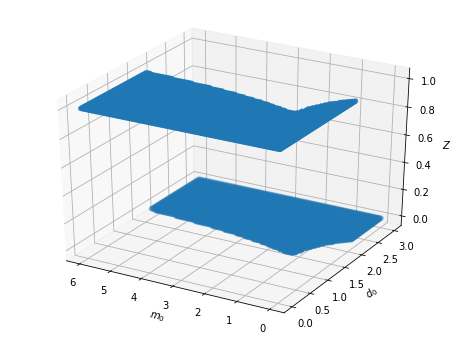

In [99]:
def utility_0(beta, m1, d, r, v2_int, Delta, Lambda, z):
    '''
    Utility function for zero period 
    
    Arguments: 
    beta(float): Discount factor
    m1(float): Cash on hand in period 0
    d(float): pre-commited durable consumption
    r(float): return on savings
    v2_int(callable): Interolation of v2 given d and m2
    Delta(float): level of income risk
    Lamda(float): Loss
    z(int): If adjusting or not
    
    Returns:
    Utility 
    '''
    if z == 0:
        # i. Value of second period utility given decreased income
        m2_low = (1+r)*(m1-d)+(1-Delta)
        v2_low = v2_int((m2_low, d))
    
        # ii. Value of second period utility given no change in income
        m2_nor = (1+r)*(m1-d) + 1
        v2_nor = v2_int((m2_nor, d))
    
         # iii. Value of second period utility given increased income
        m2_high = (1+r)*(m1-d) + (1 + Delta)
        v2_high = v2_int((m2_high, d))
    
        # iv. Take expectation
        v2 = (1/3)*v2_low + (1/3)*v2_nor + (1/3)*v2_high
    
    else:
        d_new = d*(1-Lambda)
        # i. Value of second period utility given decreased income
        m2_low = (1+r)*(m1+(1-Lambda)*d-d_new)+(1-Delta)
        v2_low = v2_int((m2_low, d_new))
    
        # ii. Value of second period utility given no change in income
        m2_nor = (1+r)*(m1+(1-Lambda)*d-d_new) + 1
        v2_nor = v2_int((m2_nor, d_new))
    
         # iii. Value of second period utility given increased income
        m2_high = (1+r)*(m1+(1-Lambda)*d-d*d_new) + (1 + Delta)
        v2_high = v2_int((m2_high, d_new))
    
        # iv. Take expectation
        v2 = (1/3)*v2_low + (1/3)*v2_nor + (1/3)*v2_high
    
    
    return beta*v2

# b. Determine what levels of m0 and d0 lead to optimal choice to switch

def best_choices_0(beta, r, v2_int, Delta, Lambda):
    ''' 
    Function used to find optimal levels of durable consumption for the next period 
    
    Arguments:
    beta(float): Discount factor
    r(float): return on savings
    v2_int(callable): Interolation of v2 given d and m2
    Delta(float): level of income risk
    Lambda(float): Loss
    
    Returns:
    m0_vec(list): List of cash on hand in period 0
    d0_vec(list): List of durable consumption at period 0
    z_vec(list): List determining if z equals 0 or 1, adjust or not
    '''
    # a. Initialize primary paramaters
    z_vec = np.empty((100,100))
    v0_vec = np.empty((100,100))
    m0_vec = np.linspace(1e-8,6,100)
    d0_vec = np.linspace(1e-8,3,100)
    
    # b. solve if individual wants to adjust their durable consumption or not with initial values
    for i,m0 in enumerate(m1_vec):
        for j,d0 in enumerate(m0_vec):
            z0 = utility_0(beta, m0, d0, r, v2_int, Delta, Lambda, 0)
            z1 = utility_0(beta, m0, d0, r, v2_int, Delta, Lambda, 1)
            if z0 > z1:
                      z_vec[i,j] = 0
            else:
                      z_vec[i,j] = 1
                      
    return m0_vec, d0_vec, z_vec

# e. Plot if indivisual adjusts or not subject to inital values of d0 and m0
m0_vec, d0_vec, z_vec = best_choices_0(beta, r, v2_int, Delta, Lambda)

# Generate meshgrid for 3d plot
m2, d = np.meshgrid(m0_vec, d0_vec, indexing='ij') 

# Create figure and plot points
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Label 
ax.set_xlabel('$m_0$')
ax.set_ylabel('$d_0$')
ax.set_zlabel('$Z$')

# Invert axis
ax.invert_xaxis()

# 3d Scatter plot
ax.scatter(m2,d,z_vec)

It can be seen from our 3d scatter plot that it is optimal to adjust the stock of durables if our d0 is low, if we have a low initial quantity of durables. As our initial quanitity of durables grows, it becomes optimal to not adjust our stock. 

# Gradient descent

Let $\boldsymbol{x} = \left[\begin{array}{c}
x_1 \\
x_2\\
\end{array}\right]$ be a two-dimensional vector. Consider the following algorithm:

**Algorithm:** `gradient_descent()`

**Goal:** Minimize the function $f(\boldsymbol{x})$.

1. Choose a tolerance $\epsilon>0$, a scale factor $ \Theta > 0$, and a small number $\Delta > 0$
2. Guess on $\boldsymbol{x}_0$ and set $n=1$
3. Compute a numerical approximation of the jacobian for $f$ by

    $$
    \nabla f(\boldsymbol{x}_{n-1}) \approx \frac{1}{\Delta}\left[\begin{array}{c}
    f\left(\boldsymbol{x}_{n-1}+\left[\begin{array}{c}
    \Delta\\
    0
    \end{array}\right]\right)-f(\boldsymbol{x}_{n-1})\\
    f\left(\boldsymbol{x}_{n-1}+\left[\begin{array}{c}
    0\\
    \Delta
    \end{array}\right]\right)-f(\boldsymbol{x}_{n-1})
    \end{array}\right]
    $$

4. Stop if the maximum element in $|\nabla f(\boldsymbol{x}_{n-1})|$ is less than $\epsilon$
5. Set $\theta = \Theta$ 
6. Compute $f^{\theta}_{n} = f(\boldsymbol{x}_{n-1} - \theta \nabla f(\boldsymbol{x}_{n-1}))$
7. If $f^{\theta}_{n} < f(\boldsymbol{x}_{n-1})$ continue to step 9
8. Set $\theta = \frac{\theta}{2}$ and return to step 6     
9. Set $x_{n} = x_{n-1} - \theta \nabla f(\boldsymbol{x}_{n-1})$
10. Set $n = n + 1$ and return to step 3

**Question:** Implement the algorithm above such that the code below can run.

**Optimizer function:**

In [107]:
# Create Gradient descent algorithm 
def gradient_descent(f,x0,epsilon=1e-6,Theta=0.1,Delta=1e-8,max_iter=10000):
    '''
    find optimal values of x using gradient descent 
    
    Arguments:
    f(callable): function to be used find optimal values of x
    x0(list): list contatining initial values of x
    epsilion(float): level of tolerance
    Theta(float): Scale Factor
    Delta(float): Difference
    max_iter(int): Maximum possible of iterations before program stops
    
    Returns:
    x(list): optimal values of x
    n(int): number of iterations to find optimal values of x
    '''
    
    # i. Set up the base paramaters 
    n = 1
    x = x0
    fx = f(x0)
    thet = Theta
    
    # ii. Iterate to find minumum
    while n < max_iter: # Find the approximation of the Jacobian 
        x_old = x
        fx_old = fx
        x1_diff = np.array([Delta, 0])
        x2_diff = np.array([0, Delta])
        f_x1 = f(x+x1_diff) - f(x)
        f_x2 = f(x+x2_diff) - f(x)
        matrix = np.array([f_x1, f_x2])
        jacobian = (1/Delta)*matrix
        
        if max(abs(jacobian[0]),abs(jacobian[1])) < epsilon: #test if maximum absolute value of jacobian is below tolerance level
            break
        
        else:
            fn = f(x_old-thet*jacobian)
            if fn < f(x_old):
                x = x - thet*jacobian
                n += 1 # Continue to iterate until optimal values are found 
            
            else:
                thet = thet/2
        
    return x, n
        

**Test case:**

In [108]:
# b. Test if algorithm functions 
def rosen(x):
    return (1.0-x[0])**2+2*(x[1]-x[0]**2)**2

x0 = np.array([1.1,1.1])
try:
    x,it = gradient_descent(rosen,x0)
    print(f'minimum found at ({x[0]:.4f},{x[1]:.4f}) after {it} iterations')
    assert np.allclose(x,[1,1])
except:
    print('not implemented yet')

minimum found at (1.0000,1.0000) after 578 iterations
